## Assignment 1: Data Prep & Simple Model Fit

1. Import `income.csv` and run your data prep function on it
2. Fit a logistic regression to predict income class using just the `age` and `hoursperweek` variables as features.
3. Take some time to interpet the impact of age on the probability someone makes over 50k. What is the impact of a one year increase in age?
4. Plot age vs. predicted probability.

In [13]:
import pandas as pd
import numpy as np

income = pd.read_csv("../Data/income.csv")

income.head()

,age,JobType,EdType,maritalstatus,occupation,relationship,race,gender,capitalgain,capitalloss,hoursperweek,nativecountry,SalStat
0,45,Private,HS-grad,Divorced,Adm-clerical,Not-in-family,White,Female,0,0,28,United-States,"less than or equal to 50,000"
1,24,Federal-gov,HS-grad,Never-married,Armed-Forces,Own-child,White,Male,0,0,40,United-States,"less than or equal to 50,000"
2,44,Private,Some-college,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,40,United-States,"greater than 50,000"
3,27,Private,9th,Never-married,Craft-repair,Other-relative,White,Male,0,0,40,Mexico,"less than or equal to 50,000"
4,20,Private,Some-college,Never-married,Sales,Not-in-family,White,Male,0,0,35,United-States,"less than or equal to 50,000"


In [14]:
def income_model_prep(data):
    from sklearn.model_selection import train_test_split
    data = pd.get_dummies(
        data.assign(
            target = np.where(data["SalStat"] == " less than or equal to 50,000", 0, 1),
            nativecountry = data["nativecountry"].replace({" Holand-Netherlands": " Germany"}),
            occupation = data["occupation"].replace({" Armed-Forces": " ?"}),
            JobType = data["JobType"].replace({" Never-worked": " Without-pay"}),
        ).drop("SalStat", axis=1), 
        drop_first=True
    )
    X = data.drop("target", axis=1)
    y = data["target"]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = income_model_prep(income)

In [17]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
lr = logreg.fit(X_train[["age", "hoursperweek"]], y_train)
lr

LogisticRegression()

In [22]:
print(f"Train data accuracy: {lr.score(X_train[['age', 'hoursperweek']], y_train)}")
print(f"Test data accuracy: {lr.score(X_test[['age', 'hoursperweek']], y_test)}")

Train data accuracy: 0.7533812837151121
Test data accuracy: 0.7570356472795498


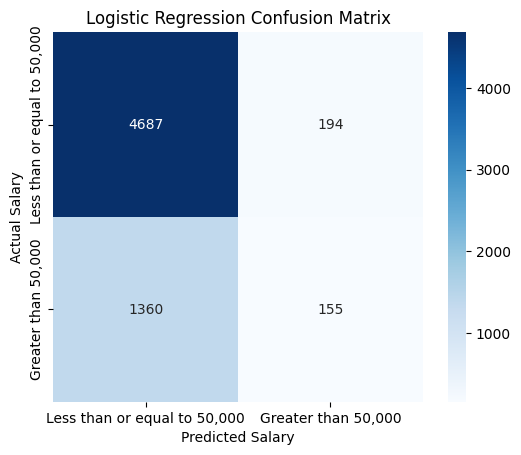

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lr_confusion = confusion_matrix(y_test, lr.predict(X_test[['age', 'hoursperweek']]))
                                 
sns.heatmap(
    lr_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);

In [23]:
np.exp(lr.coef_)

array([[1.04369717, 1.04995224]])

In [24]:
lr.coef_

array([[0.04276938, 0.04874468]])

<Axes: xlabel='age'>

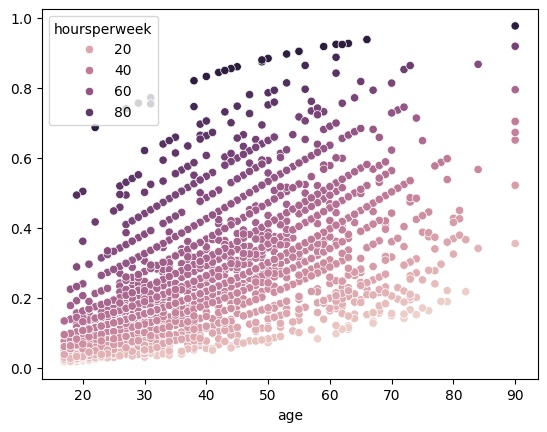

In [25]:
import seaborn as sns

sns.scatterplot(
    x=X_test['age'],
    y=lr.predict_proba(X_test[['age', 'hoursperweek']])[:, 1],
    hue = X_test["hoursperweek"]
)

## Assignment 2: Model Tuning

1. Fit a Regression using all available features - remove features if it appears there is overfitting.

2. Tune the regularization paramters once you've decided on a set of features.

In [37]:
logreg = LogisticRegression()
lr = logreg.fit(X_train, y_train)
lr

c:\Users\Jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [39]:
print(f"Train data accuracy: {lr.score(X_train, y_train)}")
print(f"Test data accuracy: {lr.score(X_test, y_test)}")

Train data accuracy: 0.8442654991791103
Test data accuracy: 0.8497498436522827


In [40]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

In [67]:
logreg = LogisticRegression(max_iter=1000)
lr = logreg.fit(X_train_std, y_train)

print(f"Train data accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test data accuracy: {lr.score(X_test_std, y_test)}")

Train data accuracy: 0.8521616761785631
Test data accuracy: 0.8567854909318324


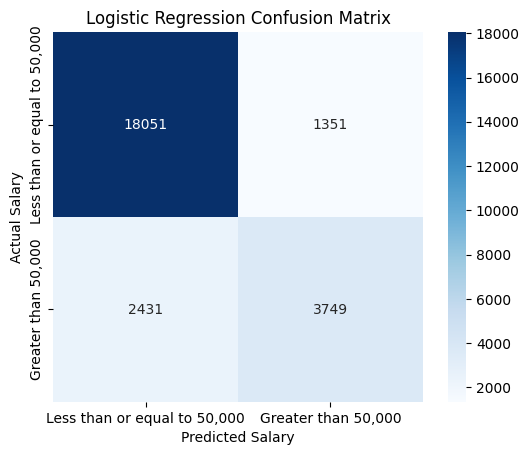

In [95]:
lr_confusion = confusion_matrix(y_train, lr.predict(X_train_std))
                                 
sns.heatmap(
    lr_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);

In [ ]:
from sklearn.model_selection import GridSearchCV

parameters = {
    "C": np.linspace(.1, 2, 20),
    "penalty": ["l1", "l2", "elasticnet"],
    "l1_ratio": np.linspace(0, 1, 11)
}

gridsearch = GridSearchCV(LogisticRegression(solver="saga"), parameters) # max_iter

gridsearch.fit(X_train_std, y_train)

gridsearch.best_params_

In [68]:
logreg = LogisticRegression(C=0.1, penalty="l2", solver="saga", max_iter=1000)

lr = logreg.fit(X_train_std, y_train)

print(f"Train Accuracy: {lr.score(X_train_std, y_train)}")
print(f"Test Accuracy: {lr.score(X_test_std, y_test)}")

Train Accuracy: 0.8522398561488547
Test Accuracy: 0.8567854909318324


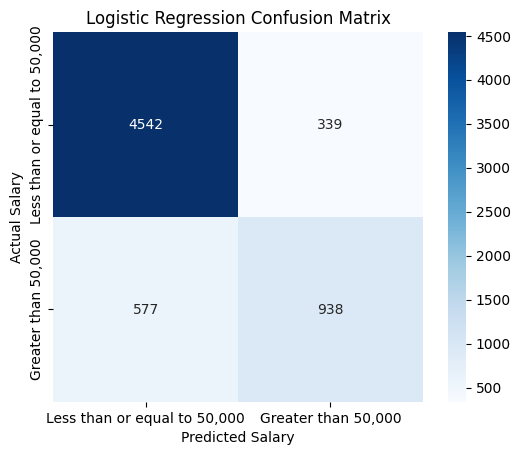

In [69]:
lr_confusion = confusion_matrix(y_test, lr.predict(X_test_std))
                                 
sns.heatmap(
    lr_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Less than or equal to 50,000", "Greater than 50,000"],        
    yticklabels=["Less than or equal to 50,000", "Greater than 50,000"]
).set(
    xlabel='Predicted Salary',
    ylabel='Actual Salary',
    title='Logistic Regression Confusion Matrix'
);

# Multiclass Logistic Regression

1. Fit a multiclass logistic regression on the data below
2. Create a confusion matrix and report accuracy score for the test data.

In [3]:
import pandas as pd

credit_df = pd.read_csv("../Data/credit_train_clean.csv").drop(["Name", "SSN"], axis=1)

credit_df.head()

,ID,Customer_ID,Month,Age,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,Num_Credit_Card,Interest_Rate,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,5634,3392,1,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,26.822620,265.0,No,49.574949,21.46538,High_spent_Small_value_payments,312.494089,Good
1,5635,3392,2,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,31.944960,266.0,No,49.574949,21.46538,Low_spent_Large_value_payments,284.629162,Good
2,5636,3392,3,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,28.609352,267.0,No,49.574949,21.46538,Low_spent_Medium_value_payments,331.209863,Good
3,5637,3392,4,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,31.377862,268.0,No,49.574949,21.46538,Low_spent_Small_value_payments,223.451310,Good
4,5638,3392,5,23.0,Scientist,19114.12,1824.843333,3.0,4.0,3.0,...,Good,809.98,24.797347,269.0,No,49.574949,21.46538,High_spent_Medium_value_payments,341.489231,Good


In [4]:
credit_df["Credit_Score"].value_counts()

Credit_Score
Standard    53174
Poor        28998
Good        17828
Name: count, dtype: int64

In [89]:
from sklearn.model_selection import train_test_split

features = [
    "Age",
    "Month",
    "Annual_Income",
    "Num_Bank_Accounts",
    "Changed_Credit_Limit",
    "Num_Credit_Card",
    "Credit_History_Age", 
    "Payment_of_Min_Amount", 
    "Monthly_Balance", 
    "Payment_Behaviour",
    "Num_Credit_Inquiries",
    "Outstanding_Debt",
    "Credit_Mix",
    "Total_EMI_per_month"
]

X = pd.get_dummies(credit_df[features], dtype="int", drop_first=True)
y = credit_df["Credit_Score"]


X_trainc, X_testc, y_trainc, y_testc = train_test_split(X, y, test_size=0.2, random_state=2023)

In [101]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)
lr.fit(X_trainc, y_trainc)

print(f"Train data accuracy: {lr.score(X_trainc, y_trainc)}")
print(f"Test data accuracy: {lr.score(X_testc, y_testc)}")

Train data accuracy: 0.617175
Test data accuracy: 0.61395


c:\Users\Jeffr\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [105]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

X_train_stdc = std.fit_transform(X_trainc)
X_test_stdc = std.transform(X_testc)

In [106]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=5000)
lr.fit(X_train_stdc, y_trainc)

print(f"Train data accuracy: {lr.score(X_train_stdc, y_trainc)}")
print(f"Test data accuracy: {lr.score(X_test_stdc, y_testc)}")

Train data accuracy: 0.647925
Test data accuracy: 0.64265


In [127]:
lr.classes_

array(['Good', 'Poor', 'Standard'], dtype=object)

In [116]:
y_trainc.value_counts()

Credit_Score
Standard    42587
Poor        23183
Good        14230
Name: count, dtype: int64

In [123]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_trainc, lr.predict(X_train_stdc))

array([[ 9469,   461,  4300],
       [ 2356, 11624,  9203],
       [ 5762,  6084, 30741]], dtype=int64)

In [125]:
y_trainc.value_counts()

Credit_Score
Standard    42587
Poor        23183
Good        14230
Name: count, dtype: int64

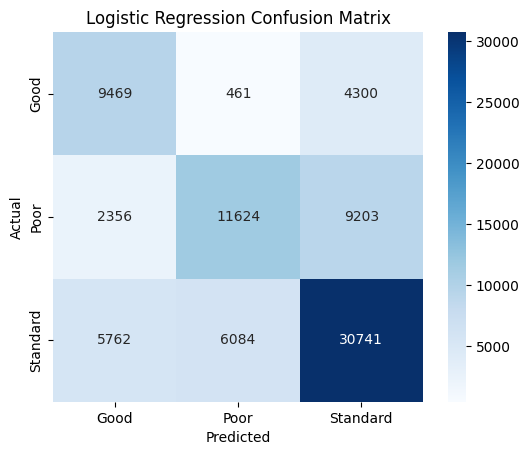

In [126]:
lr_confusion = confusion_matrix(y_trainc, lr.predict(X_train_stdc))
                                 
sns.heatmap(
    lr_confusion, 
    cmap="Blues",  
    annot=True, 
    fmt="g",
    square=True,
    xticklabels=["Good", "Poor", "Standard"],        
    yticklabels=["Good", "Poor", "Standard"]
).set(
    xlabel='Predicted',
    ylabel='Actual',
    title='Logistic Regression Confusion Matrix'
);